# Importing the libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score

# Reading the data

In [4]:
movies_path = 'https://raw.githubusercontent.com/Rakshitx1/Movie-Recomendation-System/master/Dataset/movies.csv'
ratings_path = 'https://raw.githubusercontent.com/Rakshitx1/Movie-Recomendation-System/master/Dataset/ratings.csv'
movies = pd.read_csv(movies_path)
ratings = pd.read_csv(ratings_path)

# Data Preprocessing

In [5]:
movie_ratings = pd.merge(ratings, movies, on='movieId')
movie_ratings['avg_rating'] = movie_ratings.groupby('movieId')['rating'].transform('mean')
movie_ratings.drop(['userId', 'timestamp', 'rating'], axis=1, inplace=True)
user_movie_ratings = movie_ratings.pivot_table(index='movieId', columns='title', values='avg_rating').fillna(0)

# Finding the optimal K

c:\Users\Parth\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Parth\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Parth\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Parth\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version

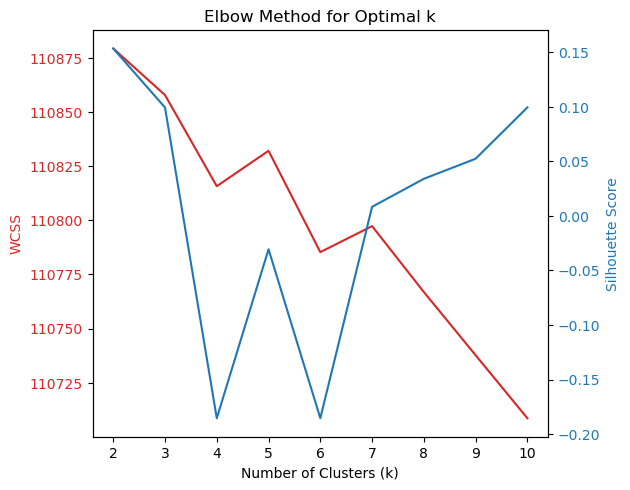

In [17]:
wcss = []
silhouette_scores = []
for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(user_movie_ratings)
  wcss.append(kmeans.inertia_)
  silhouette_scores.append(silhouette_score(user_movie_ratings, kmeans.labels_))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('WCSS', color=color)
ax1.plot(range(2, 11), wcss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(range(2, 11), silhouette_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Elbow Method for Optimal k')
plt.show()

Given the trade-off between silhouette score and WCSS, selecting k = 4 prioritizes cohesion and separation. Silhouette score, minimized at k = 4, indicates well-separated clusters. This choice aligns with the objective of maximizing the distinctiveness of clusters, crucial for effective grouping of movie preferences. Therefore, k = 4 is preferred for optimizing cluster cohesion and separation, facilitating more meaningful recommendations in the movie recommendation system. 

From the figure, K = 6 is aldo a viable option and not much difference would be observed in the results.

# Implementing K-Means

In [18]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(user_movie_ratings)
cluster_labels = kmeans.labels_
user_movie_ratings['cluster'] = cluster_labels

c:\Users\Parth\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


# Recommendation for the user

In [25]:
def recommend_movies(target_user_id, user_movie_ratings, cluster_labels):
  target_user_cluster = user_movie_ratings.loc[target_user_id, 'cluster']
  similar_users = user_movie_ratings[user_movie_ratings['cluster'] == target_user_cluster].index
  similar_users = similar_users[similar_users != target_user_id]
  target_user_ratings = user_movie_ratings.loc[target_user_id].values.reshape(1, -1)
  similar_users_ratings = user_movie_ratings.loc[similar_users]
  similarities = cosine_similarity(target_user_ratings, similar_users_ratings)[0]
  top_similar_users = similar_users[np.argsort(similarities)[::-1]][:5]
  top_movies = user_movie_ratings.loc[top_similar_users].mean().sort_values(ascending=False)
  recommendations = top_movies.head(10)
  return recommendations

target_user_id = 500
recommendations = recommend_movies(target_user_id, user_movie_ratings, cluster_labels)
print("Top 10 recommended movies for user", target_user_id, ":\n", recommendations)

Top 10 recommended movies for user 500 :
 title
cluster                                        2.0
Yongary: Monster from the Deep (1967)          0.1
God's Not Dead (2014)                          0.1
Son of God (2014)                              0.1
Secret Society (2002)                          0.1
Don't Look Now (1973)                          0.1
Partisan (2015)                                0.0
Parenthood (1989)                              0.0
Paris Is Burning (1990)                        0.0
Paris, I Love You (Paris, je t'aime) (2006)    0.0
dtype: float64
